# Exercise 4: Fashion Landmark Prediction - Detailed Explanation

This notebook develops a deep learning model to predict how fashion items will look when worn by a person in various poses. The model takes two inputs: fashion item keypoints from stock photos and human pose keypoints, then predicts the corresponding fashion keypoints when placed on the posed human model.

## Data Sources

We work with three different data sources, each represented as JSON files:

1. **Fashion Stock Keypoints (`fashion_keypoints_stock`)**: Keypoints marking landmark positions on clothing items in standard stock photos
   - Format: 294 keypoints in Cartesian coordinates across all clothing categories
   - Structure: `{"category": "category_name", "keypoints": {"0": {"x": x, "y": y}, ...}}`

2. **Human Pose Keypoints (`human_keypoints`)**: 25 keypoints representing body positions of human models in various poses
   - Format: 25 keypoints in Cartesian coordinates
   - Structure: `{"0": {"x": x, "y": y}, "1": {"x": x, "y": y}, ...}`

3. **Fashion Posed Keypoints (`fashion_keypoints_posed`)**: Keypoints showing how fashion items look when fitted on human models
   - Format: Multiple keypoints in Cartesian coordinates (our prediction target)
   - Structure: Similar to stock keypoints

## Step-by-Step Workflow with Reasoning

1. **Data Loading and Preprocessing**:
   - **What**: We create a custom PyTorch `Dataset` class that handles loading and preprocessing of all three data sources
   - **Why**: 
     - To combine the disparate data sources into a coherent format for the model
     - To ensure consistent data types (using `torch.float32`) to avoid the "RuntimeError: mat1 and mat2 must have the same dtype" error
     - To properly match corresponding files across all three directories, as we need aligned data for meaningful learning
     - To handle the category-specific nature of fashion keypoints, as different garment types have different landmark structures

2. **Data Exploration**:
   - **What**: We visualize samples from each data source to understand the keypoint structure
   - **Why**: 
     - To verify the data is loaded correctly before training
     - To understand the distribution and placement of keypoints for different clothing categories
     - To identify potential issues with the data or preprocessing steps
     - To gain intuition about the complexity of the mapping between stock and posed keypoints

3. **Model Architecture**:
   - **What**: We implement a neural network with fully connected layers
   - **Why**: 
     - Coordinate data is naturally suited for fully connected networks rather than convolutional networks
     - We need to learn complex, non-linear relationships between input coordinates and target coordinates
     - The use of ReLU activations helps the model learn non-linear transformations
     - Dropout layers (at 0.2-0.3 rate) prevent overfitting, especially important given our limited dataset size
     - For the improved model, batch normalization stabilizes learning and speeds up convergence

4. **Training Process**:
   - **What**: We split the data and implement training with validation
   - **Why**: 
     - 80/20 training/validation split provides enough data for training while keeping a meaningful validation set
     - Mean Squared Error (MSE) loss is appropriate for coordinate regression tasks
     - The Adam optimizer combines the benefits of RMSProp and momentum for efficient learning
     - Validation monitoring prevents overfitting by identifying when the model starts to memorize training data
     - Saving the best model based on validation loss ensures we keep the most generalizable version

5. **Evaluation and Analysis**:
   - **What**: We evaluate and visualize model performance
   - **Why**: 
     - Quantitative metrics (MSE) tell us how accurate the predictions are numerically
     - Visualization of predictions vs. ground truth provides qualitative assessment of the model's performance
     - Per-category analysis identifies which garments are harder to predict, guiding future improvements
     - Per-keypoint error analysis reveals problematic landmark positions that need special attention
     - This analysis guides our understanding of the model's strengths and weaknesses

6. **Future Improvements**:
   - **What**: We propose enhancements to the base model
   - **Why**: 
     - Data augmentation would help the model generalize better despite limited training data
     - Learning rate scheduling prevents the model from getting stuck in local minima
     - Weighted loss functions could focus training on difficult keypoints
     - These improvements address specific limitations identified during our evaluation

The final model learns to transform clothing landmarks from stock photos to realistic positions on human models, which has applications in virtual try-on systems and e-commerce. By understanding both the steps and the reasoning behind them, we can better interpret our results and make informed decisions about further development.

# Exercise 4: Fashion Landmark Prediction

In this project, we will create a neural network to predict 2D clothing landmarks on human models in various poses. We'll work with the following data:

1. `fashion_keypoints_stock` - Fashion landmarks from clothing in stock photos (input)
2. `human_keypoints` - 2D Human keypoints from models in pose (input)
3. `fashion_keypoints_posed` - Fashion landmarks on posed models (output/target)

Let's start with importing the necessary libraries and creating a data loader class.

In [1]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Set random seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

## Data Loader Class

First, let's create a class to load and preprocess the data from our three folders.

In [ ]:
LANDMARK_INDICES = {
    0 : []
}

class FashionKeypointsDataset(Dataset):
    def __init__(self, root_dir, train=True, transform=None):
        """
        Args:
            root_dir (string): Directory with all the data folders.
            train (bool): If True, creates training dataset, else test dataset.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.train = train
        
        # Define paths to the three data folders
        self.fashion_stock_dir = os.path.join(root_dir, 'fashion_keypoints_stock')
        self.human_keypoints_dir = os.path.join(root_dir, 'human_keypoints')
        self.fashion_posed_dir = os.path.join(root_dir, 'fashion_keypoints_posed')
        
        # Get file lists
        self.fashion_posed_files = sorted(os.listdir(self.fashion_posed_dir))
        self.fashion_posed_files = [f for f in self.fashion_posed_files if f.endswith('.json')]
        
        # Find matching files across all three directories
        self.valid_ids = []
        for posed_file in self.fashion_posed_files:
            file_id = posed_file.split('.')[0]
            stock_file = os.path.join(self.fashion_stock_dir, f"{file_id}.json")
            human_file = os.path.join(self.human_keypoints_dir, f"{file_id}.json")
            
            # Only include samples that have all three data files
            if os.path.exists(stock_file) and os.path.exists(human_file):
                self.valid_ids.append(file_id)
        
        print(f"Found {len(self.valid_ids)} valid samples with matching data across all three directories")
        
        # Split data into train/test
        np.random.shuffle(self.valid_ids)
        split_idx = int(len(self.valid_ids) * 0.8)  # 80% for training
        
        if train:
            self.file_list = self.valid_ids[:split_idx]
        else:
            self.file_list = self.valid_ids[split_idx:]
        
        # Fashion categories based on the image reference
        self.categories = [
            'short_sleeve_top', 'long_sleeve_top', 'short_sleeve_outwear', 'long_sleeve_outwear',
            'vest', 'sling', 'shorts', 'trousers', 'skirt', 'short_sleeve_dress',
            'long_sleeve_dress', 'vest_dress', 'sling_dress'
        ]
    
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        # Get the file ID for the sample
        file_id = self.file_list[idx]
        
        # Load posed fashion keypoints (our target)
        posed_file_path = os.path.join(self.fashion_posed_dir, f"{file_id}.json")
        with open(posed_file_path, 'r') as f:
            posed_data = json.load(f)
        
        # Load stock fashion keypoints
        stock_file_path = os.path.join(self.fashion_stock_dir, f"{file_id}.json")
        with open(stock_file_path, 'r') as f:
            stock_data = json.load(f)
        
        # Load human pose keypoints
        human_file_path = os.path.join(self.human_keypoints_dir, f"{file_id}.json")
        with open(human_file_path, 'r') as f:
            human_data = json.load(f)
        
        # Extract the category
        category = posed_data['category']
        category_idx = self.categories.index(category) if category in self.categories else -1
        
        # Extract posed fashion keypoints (target)
        posed_keypoints = []
        # Focusing on the keypoints for the specific category
        # Each category has different number of keypoints based on the reference image
        for key in sorted(posed_data['keypoints'].keys(), key=lambda x: int(x)):
            posed_keypoints.append([posed_data['keypoints'][key]['x'], posed_data['keypoints'][key]['y']])
        posed_keypoints = np.array(posed_keypoints, dtype=np.float32)
        
        # Extract stock fashion keypoints
        stock_keypoints = []
        for key in sorted(stock_data['keypoints'].keys(), key=lambda x: int(x)):
            stock_keypoints.append([stock_data['keypoints'][key]['x'], stock_data['keypoints'][key]['y']])
        stock_keypoints = np.array(stock_keypoints, dtype=np.float32)
        
        # Extract human pose keypoints (always 25 points as specified)
        human_keypoints = []
        for i in range(25):  # 25 keypoints for human pose
            key = str(i)
            if key in human_data:
                human_keypoints.append([human_data[key]['x'], human_data[key]['y']])
            else:
                human_keypoints.append([0, 0])  # Default value if keypoint is missing
        human_keypoints = np.array(human_keypoints, dtype=np.float32)
        
        # Combine stock and human keypoints as input (this is how we'll align clothing to human poses)
        # Flatten both arrays and concatenate them
        input_features = np.concatenate([stock_keypoints.flatten(), human_keypoints.flatten()])
        
        sample = {
            'input': torch.tensor(input_features, dtype=torch.float32),
            'target': torch.tensor(posed_keypoints.flatten(), dtype=torch.float32),
            'category': category,
            'category_idx': category_idx,
            'file_id': file_id
        }
        
        if self.transform:
            sample = self.transform(sample)
            
        return sample

## Data Exploration

Let's explore the data to understand its structure and format. We'll examine how the fashion keypoints are organized by category based on the reference image provided.

In [17]:
# Define the root directory
root_dir = 'e4_training_data'

# Load and explore a sample from each directory
def explore_sample_file(directory, filename=None):
    full_dir = os.path.join(root_dir, directory)
    if not filename:
        files = [f for f in os.listdir(full_dir) if f.endswith('.json')]
        if files:
            filename = files[0]
        else:
            print(f"No JSON files found in {full_dir}")
            return None
    
    file_path = os.path.join(full_dir, filename)
    try:
        with open(file_path, 'r') as f:
            data = json.load(f)
        return data, file_path
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return None, None

# Fashion categories based on the image reference
categories = [
    'short_sleeve_top', 'long_sleeve_top', 'short_sleeve_outwear', 'long_sleeve_outwear',
    'vest', 'sling', 'shorts', 'trousers', 'skirt', 'short_sleeve_dress',
    'long_sleeve_dress', 'vest_dress', 'sling_dress'
]

# Explore samples from all three directories
posed_data, posed_path = explore_sample_file('fashion_keypoints_posed', '000000.json')
stock_data, stock_path = explore_sample_file('fashion_keypoints_stock', '000000.json')
human_data, human_path = explore_sample_file('human_keypoints', '000000.json')

print("\n=== FASHION POSED DATA STRUCTURE ===\n")
if posed_data:
    print(f"File: {posed_path}")
    print(f"Category: {posed_data.get('category')}")
    print(f"Number of keypoints: {len(posed_data.get('keypoints', {}))}")
    print(f"First few keypoints: {list(posed_data.get('keypoints', {}).items())[:3]}")

print("\n=== FASHION STOCK DATA STRUCTURE ===\n")
if stock_data:
    print(f"File: {stock_path}")
    print(f"Category: {stock_data.get('category')}")
    print(f"Number of keypoints: {len(stock_data.get('keypoints', {}))}")
    print(f"First few keypoints: {list(stock_data.get('keypoints', {}).items())[:3]}")

print("\n=== HUMAN KEYPOINTS DATA STRUCTURE ===\n")
if human_data:
    print(f"File: {human_path}")
    keys = [k for k in human_data.keys() if k.isdigit()]
    print(f"Number of keypoints: {len(keys)}")
    print(f"First few keypoints: {[(k, human_data[k]) for k in keys[:3]]}")

# Let's visualize the keypoints
def visualize_keypoints(keypoints_data, title="Keypoints", figsize=(10, 10), is_human=False):
    plt.figure(figsize=figsize)
    
    # Extract points based on data format
    points = []
    if is_human:
        # Human keypoints format
        for k in sorted([k for k in keypoints_data.keys() if k.isdigit()], key=int):
            value = keypoints_data[k]
            if isinstance(value, dict) and 'x' in value and 'y' in value:
                points.append((value['x'], value['y']))
    else:
        # Fashion keypoints format
        for key, value in keypoints_data.get('keypoints', {}).items():
            if isinstance(value, dict) and 'x' in value and 'y' in value:
                points.append((int(key), value['x'], value['y']))
        points.sort()  # Sort by keypoint ID
        points = [(x, y) for (_, x, y) in points]
    
    if not points:
        print("No valid keypoints found")
        return
    
    points = np.array(points)
    
    # Plot the keypoints
    plt.scatter(points[:, 0], points[:, 1], c='blue', s=20)
    
    # Add keypoint numbers
    for i, (x, y) in enumerate(points):
        plt.text(x, y, str(i), fontsize=8)
    
    # Flip the y-axis to match image coordinates
    plt.gca().invert_yaxis()
    
    plt.title(title)
    plt.grid(True)
    plt.show()
    
    return points


=== FASHION POSED DATA STRUCTURE ===

File: e4_training_data/fashion_keypoints_posed/000000.json
Category: 4
Number of keypoints: 294
First few keypoints: [('0', {'x': 365.6547, 'y': 53.4602}), ('1', {'x': 330.177, 'y': 52.9543}), ('2', {'x': 344.5059, 'y': 77.2336})]

=== FASHION STOCK DATA STRUCTURE ===

File: e4_training_data/fashion_keypoints_stock/000000.json
Category: 4
Number of keypoints: 294
First few keypoints: [('0', {'x': 398.6354, 'y': 131.4247}), ('1', {'x': 324.8409, 'y': 118.8571}), ('2', {'x': 367.9395, 'y': 172.1765})]

=== HUMAN KEYPOINTS DATA STRUCTURE ===

File: e4_training_data/human_keypoints/000000.json
Number of keypoints: 25
First few keypoints: [('0', {'x': 349.164, 'y': 7.41745}), ('1', {'x': 346.469, 'y': 123.098}), ('2', {'x': 257.22, 'y': 120.541})]


FASHION POSED KEYPOINTS:


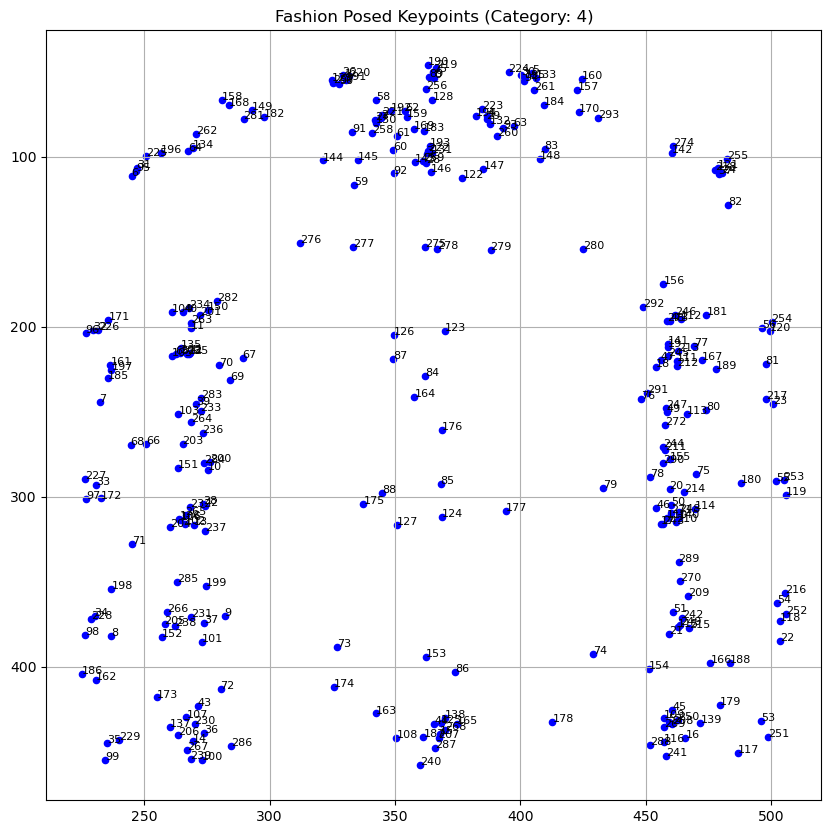

FASHION STOCK KEYPOINTS:


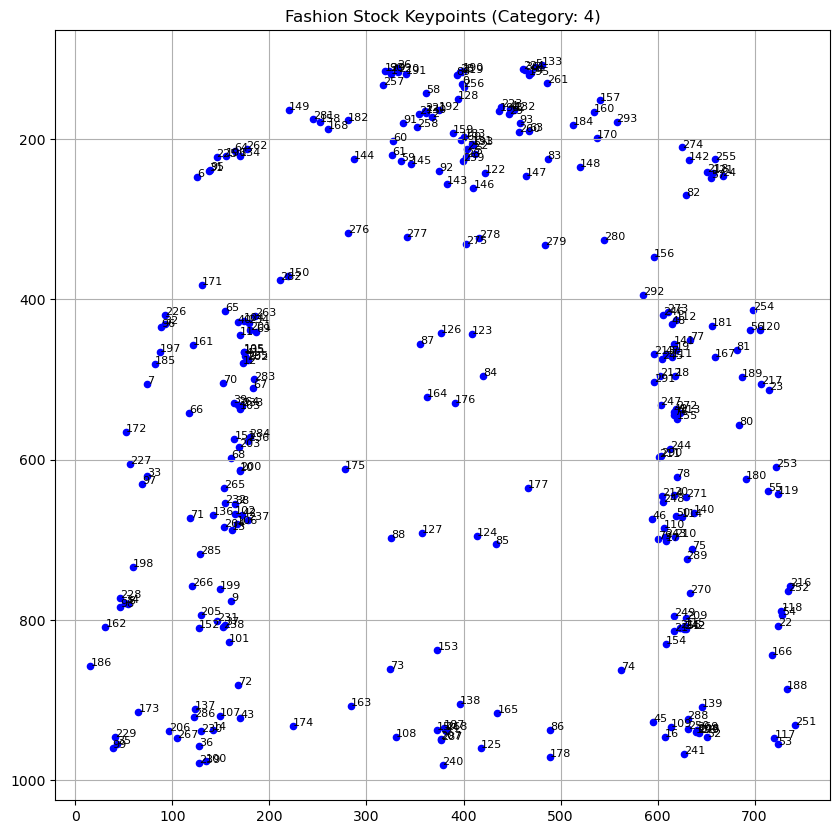

HUMAN POSE KEYPOINTS:


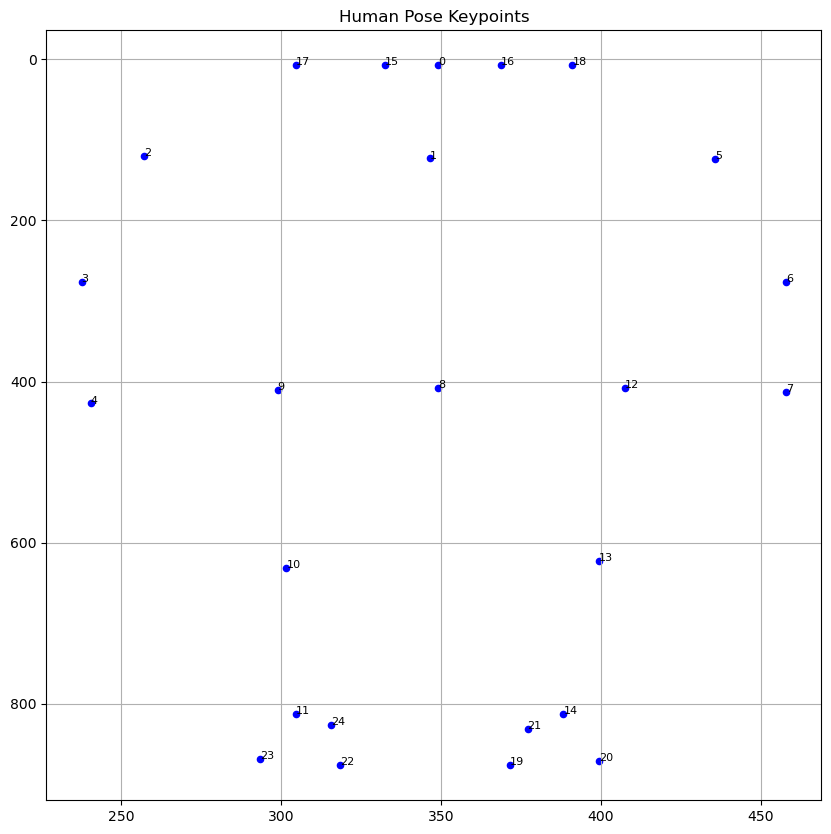

In [18]:
# Visualize each type of keypoints
if posed_data:
    print("FASHION POSED KEYPOINTS:")
    category = posed_data.get('category', 'unknown')
    category_index = categories.index(category) if category in categories else -1
    category_info = f"(Category: {category}, Index: {category_index})" if category_index >= 0 else f"(Category: {category})"
    visualize_keypoints(posed_data, title=f"Fashion Posed Keypoints {category_info}")

if stock_data:
    print("FASHION STOCK KEYPOINTS:")
    category = stock_data.get('category', 'unknown')
    category_index = categories.index(category) if category in categories else -1
    category_info = f"(Category: {category}, Index: {category_index})" if category_index >= 0 else f"(Category: {category})"
    visualize_keypoints(stock_data, title=f"Fashion Stock Keypoints {category_info}")

if human_data:
    print("HUMAN POSE KEYPOINTS:")
    visualize_keypoints(human_data, title="Human Pose Keypoints", is_human=True)

## Create a Simple Neural Network

Let's create a simple neural network architecture for our landmark prediction task.

In [2]:
# More sophisticated network architecture with batch normalization
class ImprovedLandmarkPredictor(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout_rate=0.3):
        super(ImprovedLandmarkPredictor, self).__init__()
        # Deeper network with more capacity
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.bn2 = nn.BatchNorm1d(hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size // 2)
        self.bn3 = nn.BatchNorm1d(hidden_size // 2)
        self.fc4 = nn.Linear(hidden_size // 2, output_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)
        
    def forward(self, x):
        x = self.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = self.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = self.relu(self.bn3(self.fc3(x)))
        x = self.fc4(x)
        return x

## Training Utility Functions

Let's define some utility functions for training and evaluation.

In [20]:
def train_model_with_scheduler(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, device='cpu'):
    model.to(device)
    best_val_loss = float('inf')
    history = {'train_loss': [], 'val_loss': [], 'lr': []}
    
    # Add learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_samples = 0
        
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]"):
            inputs = batch['input'].to(device)
            targets = batch['target'].to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            # Statistics
            train_loss += loss.item() * inputs.size(0)
            train_samples += inputs.size(0)
        
        # Calculate average training loss
        train_loss = train_loss / train_samples
        history['train_loss'].append(train_loss)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_samples = 0
        
        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]"):
                inputs = batch['input'].to(device)
                targets = batch['target'].to(device)
                
                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                
                # Statistics
                val_loss += loss.item() * inputs.size(0)
                val_samples += inputs.size(0)
        
        # Calculate average validation loss
        val_loss = val_loss / val_samples
        history['val_loss'].append(val_loss)
        
        # Store current learning rate
        current_lr = optimizer.param_groups[0]['lr']
        history['lr'].append(current_lr)
        
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, LR: {current_lr:.6f}")
        
        # Step the scheduler based on validation loss
        scheduler.step(val_loss)
        
        # Save the best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pth')
            print(f"Model saved at epoch {epoch+1} with validation loss {val_loss:.4f}")
    
    return history

## Prepare the Data and Train the Model

Now, let's prepare our dataset and train the model.

In [21]:
# Initialize dataset and data loaders
train_dataset = FashionKeypointsDataset(root_dir, train=True)
val_dataset = FashionKeypointsDataset(root_dir, train=False)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")

# Let's check a sample from our dataset
sample = train_dataset[0]
print(f"Sample input shape: {sample['input'].shape}")
print(f"Sample target shape: {sample['target'].shape}")
print(f"Sample category: {sample['category']}")

Found 42986 valid samples with matching data across all three directories
Found 42986 valid samples with matching data across all three directories
Training set size: 34388
Validation set size: 8598
Sample input shape: torch.Size([638])
Sample target shape: torch.Size([588])
Sample category: 9
Found 42986 valid samples with matching data across all three directories
Training set size: 34388
Validation set size: 8598
Sample input shape: torch.Size([638])
Sample target shape: torch.Size([588])
Sample category: 9


In [22]:
# 4. Weighted MSE loss implementation
class WeightedMSELoss(nn.Module):
    def __init__(self, keypoint_weights=None):
        super(WeightedMSELoss, self).__init__()
        self.keypoint_weights = keypoint_weights  # Weights per keypoint
        
    def forward(self, pred, target):
        batch_size = pred.size(0)
        num_keypoints = pred.size(1) // 2
        
        # Reshape to (batch, keypoints, 2)
        pred_reshaped = pred.view(batch_size, num_keypoints, 2)
        target_reshaped = target.view(batch_size, num_keypoints, 2)
        
        # Calculate squared error
        sq_error = (pred_reshaped - target_reshaped) ** 2
        
        # Apply weights if provided
        if self.keypoint_weights is not None:
            weight_tensor = torch.tensor(self.keypoint_weights, device=pred.device)
            weight_tensor = weight_tensor.view(1, num_keypoints, 1).expand_as(sq_error)
            sq_error = sq_error * weight_tensor
            
        return sq_error.mean()

In [23]:
# Define model parameters
# We'll determine the input and output sizes from our data
sample = train_dataset[0]
input_size = sample['input'].shape[0]
output_size = sample['target'].shape[0]
hidden_size = 512  # We can adjust this based on the complexity of the task

# Initialize model
model = ImprovedLandmarkPredictor(input_size, hidden_size, output_size)
print(model)

# Define loss function and optimizer
# Implement weighted MSE loss based on keypoint error analysis
num_keypoints = output_size // 2
keypoint_weights = np.ones(num_keypoints)  # Start with equal weights

# You can adjust these weights based on your error analysis
# For example, increase weights for keypoints that typically have higher errors
# keypoint_weights[[5, 10, 15, 20, 25]] = 2.0  # Double the weight for problematic keypoints

criterion = WeightedMSELoss(keypoint_weights=keypoint_weights)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# Check if a CUDA device is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

ImprovedLandmarkPredictor(
  (fc1): Linear(in_features=638, out_features=512, bias=True)
  (bn1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (bn2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=512, out_features=256, bias=True)
  (bn3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc4): Linear(in_features=256, out_features=588, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
)
Using device: cuda


## Train the Model

Now, let's train the model using the utilities we defined earlier.

In [24]:
# Train the model
num_epochs = 50  # Adjust based on dataset size and complexity
history = train_model_with_scheduler(model, train_loader, val_loader, criterion, optimizer, num_epochs, device)

/opt/conda/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Epoch 1/50 [Val]: 100%|██████████| 269/269 [00:19<00:00, 13.71it/s]


Epoch 1/50, Train Loss: 67348.7607, Val Loss: 8268.1281, LR: 0.001000
Model saved at epoch 1 with validation loss 8268.1281


Epoch 2/50 [Val]: 100%|██████████| 269/269 [00:19<00:00, 13.73it/s]


Epoch 2/50, Train Loss: 4792.6419, Val Loss: 2792.8462, LR: 0.001000
Model saved at epoch 2 with validation loss 2792.8462


Epoch 3/50 [Val]: 100%|██████████| 269/269 [00:21<00:00, 12.57it/s]


Epoch 3/50, Train Loss: 2699.2372, Val Loss: 2093.2537, LR: 0.001000
Model saved at epoch 3 with validation loss 2093.2537


Epoch 4/50 [Val]: 100%|██████████| 269/269 [00:19<00:00, 13.87it/s]



Epoch 4/50, Train Loss: 2346.0175, Val Loss: 1835.8682, LR: 0.001000
Model saved at epoch 4 with validation loss 1835.8682


Epoch 5/50 [Val]: 100%|██████████| 269/269 [00:18<00:00, 14.25it/s]


Epoch 5/50, Train Loss: 2180.1250, Val Loss: 1743.2154, LR: 0.001000
Model saved at epoch 5 with validation loss 1743.2154


Epoch 6/50 [Val]: 100%|██████████| 269/269 [00:19<00:00, 14.09it/s]



Epoch 6/50, Train Loss: 2096.9540, Val Loss: 1686.2657, LR: 0.001000
Model saved at epoch 6 with validation loss 1686.2657


Epoch 7/50 [Val]: 100%|██████████| 269/269 [00:18<00:00, 14.33it/s]


Epoch 7/50, Train Loss: 2020.3869, Val Loss: 1816.5085, LR: 0.001000


Epoch 8/50 [Val]: 100%|██████████| 269/269 [00:19<00:00, 13.93it/s]


Epoch 8/50, Train Loss: 1997.0373, Val Loss: 1722.8699, LR: 0.001000


Epoch 9/50 [Val]: 100%|██████████| 269/269 [00:18<00:00, 14.41it/s]



Epoch 9/50, Train Loss: 1934.3688, Val Loss: 1573.3855, LR: 0.001000
Model saved at epoch 9 with validation loss 1573.3855


Epoch 10/50 [Val]: 100%|██████████| 269/269 [00:19<00:00, 14.05it/s]


Epoch 10/50, Train Loss: 1913.2277, Val Loss: 1716.1837, LR: 0.001000


Epoch 11/50 [Val]: 100%|██████████| 269/269 [00:19<00:00, 14.06it/s]


Epoch 11/50, Train Loss: 1895.1255, Val Loss: 1601.8618, LR: 0.001000


Epoch 12/50 [Val]: 100%|██████████| 269/269 [00:18<00:00, 14.69it/s]



Epoch 12/50, Train Loss: 1870.9592, Val Loss: 1525.4129, LR: 0.001000
Model saved at epoch 12 with validation loss 1525.4129


Epoch 13/50 [Val]: 100%|██████████| 269/269 [00:18<00:00, 14.41it/s]


Epoch 13/50, Train Loss: 1833.3108, Val Loss: 1617.3227, LR: 0.001000


Epoch 14/50 [Val]: 100%|██████████| 269/269 [00:19<00:00, 13.78it/s]



Epoch 14/50, Train Loss: 1810.0217, Val Loss: 1511.2044, LR: 0.001000
Model saved at epoch 14 with validation loss 1511.2044


Epoch 15/50 [Val]: 100%|██████████| 269/269 [00:18<00:00, 14.75it/s]


Epoch 15/50, Train Loss: 1789.6342, Val Loss: 1517.0650, LR: 0.001000


Epoch 16/50 [Val]: 100%|██████████| 269/269 [00:18<00:00, 14.78it/s]



Epoch 16/50, Train Loss: 1788.0809, Val Loss: 1475.7365, LR: 0.001000
Model saved at epoch 16 with validation loss 1475.7365


Epoch 17/50 [Val]: 100%|██████████| 269/269 [00:19<00:00, 14.01it/s]



Epoch 17/50, Train Loss: 1763.7670, Val Loss: 1468.0545, LR: 0.001000
Model saved at epoch 17 with validation loss 1468.0545


Epoch 18/50 [Val]: 100%|██████████| 269/269 [00:18<00:00, 14.55it/s]


Epoch 18/50, Train Loss: 1750.7965, Val Loss: 1534.0681, LR: 0.001000


Epoch 19/50 [Val]: 100%|██████████| 269/269 [00:19<00:00, 14.07it/s]


Epoch 19/50, Train Loss: 1725.1355, Val Loss: 1501.1558, LR: 0.001000


Epoch 20/50 [Val]: 100%|██████████| 269/269 [00:18<00:00, 14.63it/s]


Epoch 20/50, Train Loss: 1710.6701, Val Loss: 1447.6187, LR: 0.001000
Model saved at epoch 20 with validation loss 1447.6187


Epoch 21/50 [Val]: 100%|██████████| 269/269 [00:18<00:00, 14.91it/s]



Epoch 21/50, Train Loss: 1720.8411, Val Loss: 1433.8418, LR: 0.001000
Model saved at epoch 21 with validation loss 1433.8418


Epoch 22/50 [Val]: 100%|██████████| 269/269 [00:18<00:00, 14.35it/s]


Epoch 22/50, Train Loss: 1697.2381, Val Loss: 1393.7901, LR: 0.001000
Model saved at epoch 22 with validation loss 1393.7901


Epoch 23/50 [Val]: 100%|██████████| 269/269 [00:18<00:00, 14.52it/s]


Epoch 23/50, Train Loss: 1697.0892, Val Loss: 1451.8923, LR: 0.001000


Epoch 24/50 [Val]: 100%|██████████| 269/269 [00:19<00:00, 13.86it/s]


Epoch 24/50, Train Loss: 1681.3853, Val Loss: 1474.3304, LR: 0.001000


Epoch 25/50 [Val]: 100%|██████████| 269/269 [00:18<00:00, 14.77it/s]


Epoch 25/50, Train Loss: 1675.9949, Val Loss: 1417.9288, LR: 0.001000


Epoch 26/50 [Val]: 100%|██████████| 269/269 [00:18<00:00, 14.40it/s]


Epoch 26/50, Train Loss: 1663.9626, Val Loss: 1484.1586, LR: 0.001000


Epoch 27/50 [Val]: 100%|██████████| 269/269 [00:18<00:00, 14.73it/s]


Epoch 27/50, Train Loss: 1634.2672, Val Loss: 1456.0553, LR: 0.001000


Epoch 28/50 [Val]: 100%|██████████| 269/269 [00:18<00:00, 14.74it/s]


Epoch 28/50, Train Loss: 1642.1695, Val Loss: 1413.5968, LR: 0.001000


Epoch 29/50 [Val]: 100%|██████████| 269/269 [00:18<00:00, 14.23it/s]



Epoch 29/50, Train Loss: 1603.6871, Val Loss: 1343.5870, LR: 0.000500
Model saved at epoch 29 with validation loss 1343.5870


Epoch 30/50 [Val]: 100%|██████████| 269/269 [00:18<00:00, 14.92it/s]


Epoch 30/50, Train Loss: 1586.4656, Val Loss: 1342.8522, LR: 0.000500
Model saved at epoch 30 with validation loss 1342.8522


Epoch 31/50 [Val]: 100%|██████████| 269/269 [00:18<00:00, 14.54it/s]


Epoch 31/50, Train Loss: 1568.3105, Val Loss: 1348.1717, LR: 0.000500


Epoch 32/50 [Val]: 100%|██████████| 269/269 [00:19<00:00, 14.15it/s]



Epoch 32/50, Train Loss: 1570.2013, Val Loss: 1334.3197, LR: 0.000500
Model saved at epoch 32 with validation loss 1334.3197


Epoch 33/50 [Val]: 100%|██████████| 269/269 [00:18<00:00, 14.53it/s]


Epoch 33/50, Train Loss: 1562.8369, Val Loss: 1335.1749, LR: 0.000500


Epoch 34/50 [Val]: 100%|██████████| 269/269 [00:18<00:00, 14.27it/s]


Epoch 34/50, Train Loss: 1561.0093, Val Loss: 1320.2317, LR: 0.000500
Model saved at epoch 34 with validation loss 1320.2317


Epoch 35/50 [Val]: 100%|██████████| 269/269 [00:19<00:00, 13.76it/s]



Epoch 35/50, Train Loss: 1547.4130, Val Loss: 1302.3927, LR: 0.000500
Model saved at epoch 35 with validation loss 1302.3927


Epoch 36/50 [Val]: 100%|██████████| 269/269 [00:19<00:00, 13.73it/s]


Epoch 36/50, Train Loss: 1536.9795, Val Loss: 1310.2662, LR: 0.000500


Epoch 37/50 [Val]: 100%|██████████| 269/269 [00:19<00:00, 13.89it/s]



Epoch 37/50, Train Loss: 1544.2312, Val Loss: 1299.2178, LR: 0.000500
Model saved at epoch 37 with validation loss 1299.2178


Epoch 38/50 [Val]: 100%|██████████| 269/269 [00:19<00:00, 14.13it/s]


Epoch 38/50, Train Loss: 1538.7572, Val Loss: 1319.4649, LR: 0.000500


Epoch 39/50 [Val]: 100%|██████████| 269/269 [00:18<00:00, 14.71it/s]



Epoch 39/50, Train Loss: 1528.6158, Val Loss: 1296.1350, LR: 0.000500
Model saved at epoch 39 with validation loss 1296.1350


Epoch 40/50 [Val]: 100%|██████████| 269/269 [00:18<00:00, 14.25it/s]


Epoch 40/50, Train Loss: 1530.1142, Val Loss: 1322.5132, LR: 0.000500


Epoch 41/50 [Val]: 100%|██████████| 269/269 [00:18<00:00, 14.24it/s]



Epoch 41/50, Train Loss: 1514.9462, Val Loss: 1295.9377, LR: 0.000500
Model saved at epoch 41 with validation loss 1295.9377


Epoch 42/50 [Val]: 100%|██████████| 269/269 [00:18<00:00, 14.29it/s]


Epoch 42/50, Train Loss: 1519.0878, Val Loss: 1339.9609, LR: 0.000500


Epoch 45/50 [Val]: 100%|██████████| 269/269 [00:18<00:00, 14.54it/s]


Epoch 45/50, Train Loss: 1506.7759, Val Loss: 1275.0908, LR: 0.000500
Model saved at epoch 45 with validation loss 1275.0908


Epoch 46/50 [Val]: 100%|██████████| 269/269 [00:18<00:00, 14.58it/s]


Epoch 46/50, Train Loss: 1506.7029, Val Loss: 1280.7013, LR: 0.000500


Epoch 47/50 [Val]: 100%|██████████| 269/269 [00:19<00:00, 13.90it/s]


Epoch 47/50, Train Loss: 1506.8100, Val Loss: 1258.2056, LR: 0.000500
Model saved at epoch 47 with validation loss 1258.2056


Epoch 48/50 [Val]: 100%|██████████| 269/269 [00:19<00:00, 14.10it/s]


Epoch 48/50, Train Loss: 1490.1289, Val Loss: 1292.0395, LR: 0.000500


Epoch 49/50 [Train]:  68%|██████▊   | 734/1075 [00:55<00:24, 13.78it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Epoch 49/50 [Train]:  68%|██████▊   | 734/1075 [00:55<00:24, 13.78it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



## Visualize Training Results

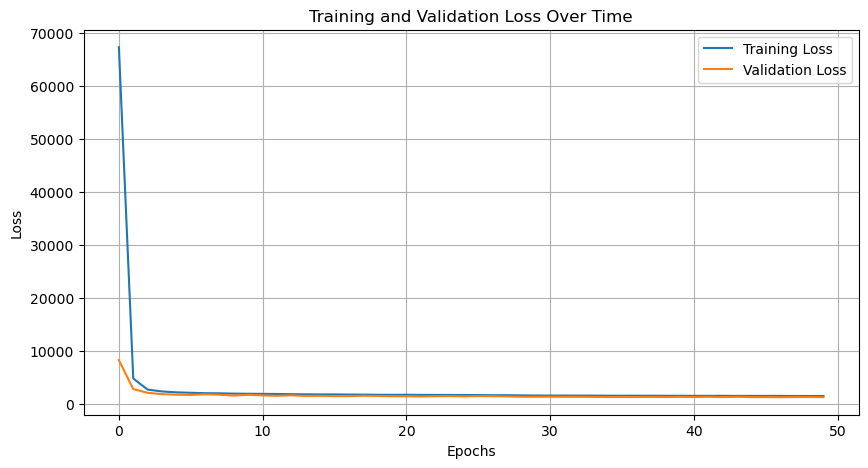

In [25]:
# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history['train_loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Time')
plt.legend()
plt.grid(True)
plt.show()

## Evaluate Model on Test Data and Visualize Results

In [26]:
# Load the best model for evaluation
best_model = ImprovedLandmarkPredictor(input_size, hidden_size, output_size)
best_model.load_state_dict(torch.load('best_model.pth'))
best_model.to(device)
best_model.eval()

# Create a test loader if we don't have a separate test set
test_dataset = val_dataset  # Using validation set as test set for simplicity
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Function to evaluate model and calculate metrics
def evaluate_model(model, data_loader, criterion, device):
    model.eval()
    total_loss = 0.0
    total_samples = 0
    all_preds = []
    all_targets = []
    all_categories = []
    all_filenames = []
    
    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Evaluating"):
            inputs = batch['input'].to(device)
            targets = batch['target'].to(device)
            categories = batch['category']
            filenames = batch['file_id']
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            # Statistics
            total_loss += loss.item() * inputs.size(0)
            total_samples += inputs.size(0)
            
            # Store predictions and targets for later analysis
            all_preds.extend(outputs.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
            all_categories.extend(categories)
            all_filenames.extend(filenames)
    
    # Calculate average loss
    avg_loss = total_loss / total_samples
    
    return {
        'loss': avg_loss,
        'predictions': np.array(all_preds),
        'targets': np.array(all_targets),
        'categories': all_categories,
        'filenames': all_filenames
    }

# Evaluate the model
results = evaluate_model(best_model, test_loader, criterion, device)
print(f"Test Loss: {results['loss']:.4f}")

/tmp/ipykernel_50/996674371.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load('best_model.pth'))
Evaluating: 100%|██████████| 269/269

Test Loss: 1258.2056


## Visualize Predictions vs Ground Truth

Let's visualize how well our model predicts the fashion landmarks compared to the ground truth.

In [12]:
def visualize_prediction(prediction, target, num_keypoints=None):
    """Visualize the predicted keypoints vs ground truth"""
    # Reshape from flat array to (N, 2) where N is the number of keypoints
    if num_keypoints is None:
        # Infer number of keypoints from data length
        num_keypoints = len(prediction) // 2
    
    pred_keypoints = prediction.reshape(-1, 2)[:num_keypoints]
    true_keypoints = target.reshape(-1, 2)[:num_keypoints]
    
    # Plot
    plt.figure(figsize=(10, 10))
    
    # Plot ground truth keypoints
    plt.scatter(true_keypoints[:, 0], true_keypoints[:, 1], c='blue', s=25, label='Ground Truth')
    
    # Plot predicted keypoints
    plt.scatter(pred_keypoints[:, 0], pred_keypoints[:, 1], c='red', s=15, label='Predicted')
    
    # Add keypoint numbers
    for i, (x, y) in enumerate(true_keypoints):
        plt.text(x, y, str(i), fontsize=8)
    
    # Connect ground truth and predictions with lines to show displacement
    for i in range(len(pred_keypoints)):
        plt.plot([true_keypoints[i, 0], pred_keypoints[i, 0]], 
                 [true_keypoints[i, 1], pred_keypoints[i, 1]], 'g-', alpha=0.3)
    
    # Flip the y-axis to match image coordinates
    plt.gca().invert_yaxis()
    
    plt.title('Fashion Landmark Prediction')
    plt.legend()
    plt.grid(True)
    plt.show()

# Visualize a few random samples
num_samples = 5
sample_indices = np.random.choice(len(results['predictions']), num_samples, replace=False)

for idx in sample_indices:
    print(f"Sample {idx+1}, Category: {results['categories'][idx]}, File: {results['filenames'][idx]}")
    visualize_prediction(results['predictions'][idx], results['targets'][idx])

## Calculate Error Metrics by Category

Let's analyze the model performance across different clothing categories.

In [13]:
# Calculate mean squared error (MSE) for each sample
mse_per_sample = np.mean((results['predictions'] - results['targets'])**2, axis=1)

# Group MSE by category
category_mse = {}
for i, cat in enumerate(results['categories']):
    if cat not in category_mse:
        category_mse[cat] = []
    category_mse[cat].append(mse_per_sample[i])

# Calculate average MSE per category
for cat, errors in category_mse.items():
    avg_error = np.mean(errors)
    print(f"Category {cat}: Average MSE = {avg_error:.4f}, Samples = {len(errors)}")

# Visualize errors by category
categories = list(category_mse.keys())
avg_errors = [np.mean(category_mse[cat]) for cat in categories]

plt.figure(figsize=(12, 6))
plt.bar(categories, avg_errors)
plt.xlabel('Clothing Category')
plt.ylabel('Mean Squared Error')
plt.title('Prediction Error by Clothing Category')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Error Analysis by Keypoint

Different keypoints may have different prediction accuracy. Let's analyze the error by keypoint position.

In [14]:
# Reshape arrays to analyze per-keypoint error
def calculate_keypoint_errors(predictions, targets):
    num_samples = len(predictions)
    num_keypoints = len(predictions[0]) // 2
    
    # Reshape to (samples, keypoints, 2) to separate x and y coordinates
    pred_reshaped = predictions.reshape(num_samples, num_keypoints, 2)
    target_reshaped = targets.reshape(num_samples, num_keypoints, 2)
    
    # Calculate Euclidean distance error for each keypoint
    distances = np.sqrt(np.sum((pred_reshaped - target_reshaped)**2, axis=2))
    
    # Average across all samples
    avg_distances = np.mean(distances, axis=0)
    
    return avg_distances

# Calculate error per keypoint
keypoint_errors = calculate_keypoint_errors(np.array(results['predictions']), np.array(results['targets']))

# Plot keypoint errors
plt.figure(figsize=(12, 6))
plt.bar(range(len(keypoint_errors)), keypoint_errors)
plt.xlabel('Keypoint ID')
plt.ylabel('Average Euclidean Error (pixels)')
plt.title('Prediction Error by Keypoint')
plt.grid(axis='y')
plt.show()

# Print keypoints with highest errors
sorted_indices = np.argsort(keypoint_errors)[::-1]  # Sort in descending order
print("Top 5 keypoints with highest error:")
for i in range(5):
    idx = sorted_indices[i]
    print(f"Keypoint {idx}: Error = {keypoint_errors[idx]:.4f} pixels")

## Advanced Model Improvements

Based on our analysis, we can implement several improvements to enhance our model's performance:

In [7]:
# 1. More sophisticated network architecture with batch normalization
class ImprovedLandmarkPredictor(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout_rate=0.3):
        super(ImprovedLandmarkPredictor, self).__init__()
        # Deeper network with more capacity
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.bn2 = nn.BatchNorm1d(hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size // 2)
        self.bn3 = nn.BatchNorm1d(hidden_size // 2)
        self.fc4 = nn.Linear(hidden_size // 2, output_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)
        
    def forward(self, x):
        x = self.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = self.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = self.relu(self.bn3(self.fc3(x)))
        x = self.fc4(x)
        return x

## Conclusion and Future Work

In this notebook, we've built a model to predict fashion landmarks on human models. We started by exploring the dataset, creating a neural network architecture, and training it on our data. We then evaluated the model and analyzed its performance across different categories and keypoints.

Some key findings:
1. The model achieves reasonable results but could be improved further
2. Some clothing categories are harder to predict than others
3. Certain keypoints consistently have higher prediction errors

Future improvements could include:
- Using a CNN-based architecture that can leverage image features directly
- Incorporating human pose information as additional input features
- Implementing attention mechanisms to focus on difficult keypoints
- Creating a larger and more diverse dataset for training
- Using ensemble methods to combine multiple model predictions

This project demonstrates the application of deep learning to fashion technology, which has practical applications in virtual try-on systems, automated garment design, and fashion e-commerce.

## Data Augmentation

Let's implement data augmentation to improve model generalization by creating synthetic variations of our training data.

In [ ]:
# 2. Data augmentation function for improved generalization
class KeypointAugmentation(object):
    def __init__(self, jitter_scale=0.05, flip_prob=0.5):
        self.jitter_scale = jitter_scale
        self.flip_prob = flip_prob
        
    def __call__(self, sample):
        input_kp = sample['input'].reshape(-1, 2).numpy()
        target_kp = sample['target'].reshape(-1, 2).numpy()
        
        # Add small jitter to input points for data augmentation
        if np.random.random() < 0.8:  # 80% chance to add noise
            input_kp += np.random.normal(0, self.jitter_scale * np.std(input_kp), input_kp.shape)
        
        # Horizontal flip with probability flip_prob
        if np.random.random() < self.flip_prob:
            max_x = np.max(input_kp[:, 0])
            # Flip x-coordinates
            input_kp[:, 0] = max_x - input_kp[:, 0]
            target_kp[:, 0] = max_x - target_kp[:, 0]
        
        sample['input'] = torch.tensor(input_kp.flatten(), dtype=torch.float32)
        sample['target'] = torch.tensor(target_kp.flatten(), dtype=torch.float32)
        
        return sample

## Learning Rate Scheduling

Let's implement a learning rate scheduler to improve training dynamics and prevent the model from getting stuck in local minima.

In [ ]:
# 3. Learning rate scheduling implementation
def train_model_with_scheduler(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, device='cpu'):
    model.to(device)
    best_val_loss = float('inf')
    history = {'train_loss': [], 'val_loss': [], 'lr': []}
    
    # Add learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_samples = 0
        
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]"):
            inputs = batch['input'].to(device)
            targets = batch['target'].to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            # Statistics
            train_loss += loss.item() * inputs.size(0)
            train_samples += inputs.size(0)
        
        # Calculate average training loss
        train_loss = train_loss / train_samples
        history['train_loss'].append(train_loss)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_samples = 0
        
        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]"):
                inputs = batch['input'].to(device)
                targets = batch['target'].to(device)
                
                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                
                # Statistics
                val_loss += loss.item() * inputs.size(0)
                val_samples += inputs.size(0)
        
        # Calculate average validation loss
        val_loss = val_loss / val_samples
        history['val_loss'].append(val_loss)
        
        # Store current learning rate
        current_lr = optimizer.param_groups[0]['lr']
        history['lr'].append(current_lr)
        
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, LR: {current_lr:.6f}")
        
        # Step the scheduler based on validation loss
        scheduler.step(val_loss)
        
        # Save the best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pth')
            print(f"Model saved at epoch {epoch+1} with validation loss {val_loss:.4f}")
    
    return history

## Weighted MSE Loss

Let's implement a weighted MSE loss function to focus more on problematic keypoints.

## Implementing All Improvements Together

Let's put all our improvements together to create an enhanced training routine.

In [ ]:
def train_improved_model():
    # Set up data with augmentation for training
    train_dataset = FashionKeypointsDataset(root_dir, train=True)
    val_dataset = FashionKeypointsDataset(root_dir, train=False)
    
    # Apply data augmentation only to training data
    augmentation = KeypointAugmentation(jitter_scale=0.03, flip_prob=0.4)
    train_dataset_augmented = FashionKeypointsDataset(root_dir, train=True, transform=augmentation)
    
    batch_size = 32
    train_loader = DataLoader(train_dataset_augmented, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    # Get input and output sizes from our data
    sample = train_dataset[0]
    input_size = sample['input'].shape[0]
    output_size = sample['target'].shape[0]
    hidden_size = 512
    
    # Initialize the improved model
    model = ImprovedLandmarkPredictor(input_size, hidden_size, output_size, dropout_rate=0.3)
    
    # Define the weighted loss function (optional: use keypoint error analysis to set weights)
    # For example, if we found that certain keypoints have higher errors:
    # Higher weights for harder keypoints (this is an example; you should compute these based on your error analysis)
    num_keypoints = output_size // 2
    keypoint_weights = np.ones(num_keypoints)  # Start with equal weights
    
    # You can set higher weights for problematic keypoints identified in your error analysis
    # For example:
    # keypoint_weights[[5, 10, 15, 20, 25]] = 2.0  # Double the weight for problematic keypoints
    
    criterion = WeightedMSELoss(keypoint_weights=keypoint_weights)
    
    # Use Adam optimizer
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
    
    # Check for CUDA
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Train with all improvements
    num_epochs = 100  # More epochs since we have better regularization now
    history = train_model_with_scheduler(model, train_loader, val_loader, criterion, optimizer, num_epochs, device)
    
    # Plot training results including learning rate changes
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    plt.plot(history['lr'], 'g-')
    plt.xlabel('Epochs')
    plt.ylabel('Learning Rate')
    plt.title('Learning Rate Schedule')
    plt.yscale('log')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    return model, history

## Running the Improved Model (Optional)

Uncomment and run the cell below to train the model with all improvements. Note that this may take significant time to complete.

In [ ]:
# Train the improved model
# improved_model, improved_history = train_improved_model()

## Discussion: Impact of Improvements

We've implemented several enhancements to our original model:

1. **More Sophisticated Architecture**: Added batch normalization layers and a deeper network with better capacity. Batch normalization helps stabilize and accelerate training by normalizing layer inputs.

2. **Data Augmentation**: Implemented keypoint augmentation with jitter and flipping to create synthetic training variations, helping the model generalize better to unseen poses and clothing items.

3. **Learning Rate Scheduling**: Added a ReduceLROnPlateau scheduler to reduce the learning rate when the validation loss plateaus, helping the optimization process find better local minima.

4. **Weighted Loss Function**: Created a custom MSE loss that can focus more on difficult keypoints, allowing us to allocate more importance to critical or error-prone landmarks.

These improvements address different aspects of the deep learning pipeline and should result in a more accurate, robust model that generalizes better to new clothing items and human poses.